In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import svm
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

##rearange 12 samples to one, because it's a time series
def reara12(arr):
    old_arr = arr
    rows, cols = len(old_arr), len(old_arr[0])
    new_arr = np.arange(rows * cols, dtype=float).reshape((int)(rows / 12), cols * 12)
    
    i_new = 0
    for i_old in range (0, rows, 12):        
        new_row = old_arr[i_old]
        for i in range (1, 12):
            new_row = np.append(new_row, old_arr[i_old + i])                    
        new_arr[i_new] = new_row
        i_new += 1
        
    return new_arr

##sometimes overflows
def sigmoid(x):
    sig = (1 / (1 + np.exp(-x)))
    return sig

sigmoid_v = np.vectorize(sigmoid)

In [2]:
##init X         
X = pd.read_csv("train_features.csv")

##init y
y = pd.read_csv("train_labels.csv")


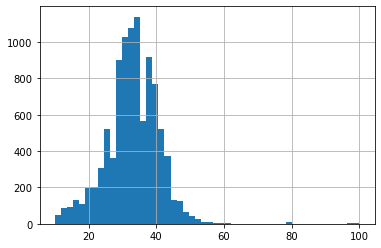

In [3]:
# outlier removal
# followed by 
X.EtCO2.hist(bins = 50);

In [4]:
mv_row_indices = (X.isnull().sum()/ X.shape[0])*100 > 90
mv_row_indices

pid                 False
Time                False
Age                 False
EtCO2                True
PTT                  True
BUN                  True
Lactate              True
Temp                False
Hgb                  True
HCO3                 True
BaseExcess           True
RRate               False
Fibrinogen           True
Phosphate            True
WBC                  True
Creatinine           True
PaCO2                True
AST                  True
FiO2                False
Platelets            True
SaO2                 True
Glucose             False
ABPm                False
Magnesium            True
Potassium           False
ABPd                False
Calcium              True
Alkalinephos         True
SpO2                False
Bilirubin_direct     True
Chloride             True
Hct                 False
Heartrate           False
Bilirubin_total      True
TroponinI            True
ABPs                False
pH                  False
dtype: bool

In [5]:
drop_ind = []
for i in range (len(mv_row_indices.values)):
    if mv_row_indices.values[i]: drop_ind += [i]
        
drop_ind

[3,
 4,
 5,
 6,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 23,
 26,
 27,
 29,
 30,
 33,
 34]

In [6]:
X_val = X.drop(X.columns[drop_ind], axis=1)
X_val

,pid,Time,Age,Temp,RRate,FiO2,Glucose,ABPm,Potassium,ABPd,SpO2,Hct,Heartrate,ABPs,pH
0,1,3,34.0,36.0,16.0,NaN,NaN,84.0,3.8,61.0,100.0,24.6,94.0,142.0,7.33
1,1,4,34.0,36.0,16.0,0.5,NaN,81.0,NaN,62.5,100.0,NaN,99.0,125.0,7.33
2,1,5,34.0,36.0,18.0,0.4,NaN,74.0,NaN,59.0,100.0,NaN,92.0,110.0,7.37
3,1,6,34.0,37.0,18.0,NaN,NaN,66.0,NaN,49.5,100.0,NaN,88.0,104.0,7.37
4,1,7,34.0,NaN,18.0,NaN,NaN,63.0,NaN,48.0,100.0,22.4,81.0,100.0,7.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227935,9999,8,85.0,NaN,17.0,NaN,NaN,78.0,NaN,NaN,NaN,NaN,80.0,110.0,NaN
227936,9999,9,85.0,NaN,15.0,NaN,NaN,88.0,NaN,NaN,NaN,NaN,83.0,123.0,NaN
227937,9999,10,85.0,36.0,22.0,NaN,NaN,97.0,NaN,NaN,98.0,NaN,80.0,138.0,NaN
227938,9999,11,85.0,NaN,22.0,NaN,NaN,84.0,NaN,NaN,98.0,31.0,75.0,125.0,NaN


In [7]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_val)
X_val = imp.transform(X_val)
X_val = X_val[:,1:]

X_val

array([[  3.        ,  34.        ,  36.        , ...,  94.        ,
        142.        ,   7.33      ],
       [  4.        ,  34.        ,  36.        , ...,  99.        ,
        125.        ,   7.33      ],
       [  5.        ,  34.        ,  36.        , ...,  92.        ,
        110.        ,   7.37      ],
       ...,
       [ 10.        ,  85.        ,  36.        , ...,  80.        ,
        138.        ,   7.36723149],
       [ 11.        ,  85.        ,  36.85213586, ...,  75.        ,
        125.        ,   7.36723149],
       [ 12.        ,  85.        ,  36.85213586, ...,  79.        ,
        128.        ,   7.36723149]])

In [8]:
scaler = preprocessing.StandardScaler().fit(X_val)
X_val = scaler.transform(X_val)
X_val

array([[-8.51212785e-01, -1.70642596e+00, -1.63225346e+00, ...,
         5.73289450e-01,  9.19839542e-01, -1.51001649e+00],
       [-6.39172854e-01, -1.70642596e+00, -1.63225346e+00, ...,
         8.75732937e-01,  1.23243794e-01, -1.51001649e+00],
       [-4.27132924e-01, -1.70642596e+00, -1.63225346e+00, ...,
         4.52312056e-01, -5.79634807e-01,  1.12283693e-01],
       ...,
       [ 6.33066729e-01,  1.39353544e+00, -1.63225346e+00, ...,
        -2.73552311e-01,  7.32405248e-01, -1.08066901e-13],
       [ 8.45106660e-01,  1.39353544e+00,  2.72206792e-14, ...,
        -5.75995797e-01,  1.23243794e-01, -1.08066901e-13],
       [ 1.05714659e+00,  1.39353544e+00,  2.72206792e-14, ...,
        -3.34041008e-01,  2.63819514e-01, -1.08066901e-13]])

In [9]:
X_val = reara12(X_val)
X_val

array([[-8.51212785e-01, -1.70642596e+00, -1.63225346e+00, ...,
        -9.38927981e-01, -9.54503395e-01, -1.08066901e-13],
       [-1.27529265e+00,  5.42565645e-01,  2.72206792e-14, ...,
        -5.75995797e-01,  6.38688101e-01, -1.08066901e-13],
       [-1.06325272e+00,  3.60214974e-01, -3.54773847e+00, ...,
         1.72257470e+00, -2.98483367e-01, -1.08066901e-13],
       ...,
       [-3.05306244e-03, -5.51538380e-01,  2.83231550e-01, ...,
         6.33778148e-01, -1.28251341e+00, -1.08066901e-13],
       [-1.27529265e+00,  1.63666967e+00,  2.72206792e-14, ...,
         9.36221634e-01,  1.57585957e+00, -1.08066901e-13],
       [-1.27529265e+00,  1.39353544e+00,  2.72206792e-14, ...,
        -3.34041008e-01,  2.63819514e-01, -1.08066901e-13]])

In [10]:
y_ind0 = np.array(y.index[y["LABEL_Sepsis"] == 0].tolist())
y_ind1 = np.array(y.index[y["LABEL_Sepsis"] == 1].tolist())

copy_ind = np.random.choice(y_ind1, len(y_ind0) - len(y_ind1), replace=True)
copy_ind

array([ 6131, 17486, 16852, ...,  6445,  9140, 18009])

In [11]:
os_samples = X_val[copy_ind[0]]
os_samples = os_samples.reshape(1,os_samples.shape[0])
os_samples

array([[-1.27529265e+00, -1.15937395e+00,  2.72206792e-14,
         0.00000000e+00, -2.65059517e-17, -1.09971305e-15,
         0.00000000e+00,  3.75516567e-15,  0.00000000e+00,
        -1.10235233e-14,  0.00000000e+00,  0.00000000e+00,
        -1.33180076e-15, -1.08066901e-13, -1.06325272e+00,
        -1.15937395e+00,  2.83231550e-01, -1.12733878e+00,
        -2.65059517e-17, -1.09971305e-15,  3.19761110e-01,
         3.75516567e-15,  4.37967279e-01, -1.10235233e-14,
         0.00000000e+00,  5.73289450e-01,  7.32405248e-01,
         1.12283693e-01, -8.51212785e-01, -1.15937395e+00,
         2.72206792e-14,  0.00000000e+00, -2.65059517e-17,
         4.96450469e-01,  0.00000000e+00,  3.75516567e-15,
         0.00000000e+00, -1.10235233e-14, -2.64570221e+00,
         0.00000000e+00, -1.33180076e-15, -4.75461686e+00,
        -6.39172854e-01, -1.15937395e+00,  2.72206792e-14,
         0.00000000e+00, -2.65059517e-17, -8.57794491e-01,
         0.00000000e+00,  3.75516567e-15,  0.00000000e+0

In [12]:
for i in copy_ind[1:]:
    copy_sample = X_val[i]
    os_samples = np.concatenate((os_samples, copy_sample.reshape(1, copy_sample.shape[0])), axis=0)
os_samples

array([[-1.27529265e+00, -1.15937395e+00,  2.72206792e-14, ...,
         1.29915382e+00, -4.85917661e-01, -2.32116658e+00],
       [ 2.08986868e-01, -8.55456164e-01, -1.63225346e+00, ...,
        -3.15975221e-02, -1.04822054e+00, -1.08066901e-13],
       [-1.27529265e+00, -9.77023278e-01,  2.72206792e-14, ...,
         3.31334661e-01, -1.18879626e+00, -1.08066901e-13],
       ...,
       [-6.39172854e-01, -7.94672607e-01,  2.83231550e-01, ...,
         0.00000000e+00, -1.33180076e-15, -8.40479227e+00],
       [-6.39172854e-01,  4.81782088e-01, -3.54773847e+00, ...,
         2.88911752e-02, -9.54503395e-01, -2.72674163e+00],
       [-1.27529265e+00, -1.26053481e-01,  2.72206792e-14, ...,
        -6.36484495e-01,  2.93475820e+00, -1.08066901e-13]])

In [14]:
X_val = np.concatenate((X_val, os_samples), axis=0)
X_val

array([[-8.51212785e-01, -1.70642596e+00, -1.63225346e+00, ...,
        -9.38927981e-01, -9.54503395e-01, -1.08066901e-13],
       [-1.27529265e+00,  5.42565645e-01,  2.72206792e-14, ...,
        -5.75995797e-01,  6.38688101e-01, -1.08066901e-13],
       [-1.06325272e+00,  3.60214974e-01, -3.54773847e+00, ...,
         1.72257470e+00, -2.98483367e-01, -1.08066901e-13],
       ...,
       [-6.39172854e-01, -7.94672607e-01,  2.83231550e-01, ...,
         0.00000000e+00, -1.33180076e-15, -8.40479227e+00],
       [-6.39172854e-01,  4.81782088e-01, -3.54773847e+00, ...,
         2.88911752e-02, -9.54503395e-01, -2.72674163e+00],
       [-1.27529265e+00, -1.26053481e-01,  2.72206792e-14, ...,
        -6.36484495e-01,  2.93475820e+00, -1.08066901e-13]])

In [15]:
y_val = np.concatenate((y["LABEL_Sepsis"].values, np.ones(len(os_samples), dtype = float)), axis=0)

y_val.shape

(35814,)

In [16]:
m = svm.SVC(C=0.8, kernel="poly", degree=5, decision_function_shape="ovo")
m.fit(X_val,y_val)

SVC(C=0.8, decision_function_shape='ovo', degree=5, kernel='poly')

In [20]:
X_test = X.drop(X.columns[drop_ind], axis=1)
X_test = imp.transform(X_test)
X_test = X_test[:,1:]
X_test = scaler.transform(X_test)
X_test = reara12(X_test)

y_dec = m.decision_function(X_test)
y_dec_prob = sigmoid_v(y_dec)
y_true = y["LABEL_Sepsis"]
##print(roc_auc_score(y_true, y_dec_prob))
y_dec

array([-0.99999997, -0.99999975, -0.99999976, ..., -1.05182365,
       -0.99999973, -0.9999997 ])

In [21]:
roc_auc_score(y_true, y_dec_prob)

0.99053304204074